In [ ]:
import os
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':16:8'
os.environ['PYTHONHASHSEED'] = '42'

import random
random.seed(42)

import numpy as np
np.random.seed(42)

import torch
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from huggingface_hub import snapshot_download
from huggingface_hub import hf_hub_download
from tqdm import tqdm
import yaml
import os
import ruamel.yaml
import cv2 as cv
import json
import numpy as np
import matplotlib.pyplot as plt
import shutil
from decord import VideoReader, cpu, gpu
import concurrent.futures
from ultralytics import YOLO
from multiprocessing import Pool
import glob
from pathlib import Path
from scipy.optimize import linear_sum_assignment
import torch
import torchvision.transforms as transforms
import torchreid
import h5py
import pprint
from PIL import Image
import torch.nn.functional as F
import math
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import pdist, squareform
import random
from collections import deque, defaultdict
import re

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
download_list = ['videos'  , 'ground_truth.json' , 'calibration.json' , 'map.png']

for j in tqdm([0]):
  for i in download_list:
    snapshot_download(
      repo_id="nvidia/PhysicalAI-SmartSpaces",
      repo_type="dataset",
      allow_patterns=[f"MTMC_Tracking_2025/train/Warehouse_{j:03d}/{i}*"]
    )

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

Camera_0000.mp4:   0%|          | 0.00/170M [00:00<?, ?B/s]

Camera_0006.mp4:   0%|          | 0.00/82.6M [00:00<?, ?B/s]

Camera_0003.mp4:   0%|          | 0.00/160M [00:00<?, ?B/s]

Camera_0002.mp4:   0%|          | 0.00/160M [00:00<?, ?B/s]

Camera_0004.mp4:   0%|          | 0.00/176M [00:00<?, ?B/s]

Camera_0005.mp4:   0%|          | 0.00/120M [00:00<?, ?B/s]

Camera_0001.mp4:   0%|          | 0.00/171M [00:00<?, ?B/s]

Camera_0007.mp4:   0%|          | 0.00/145M [00:00<?, ?B/s]

Camera_0008.mp4:   0%|          | 0.00/91.3M [00:00<?, ?B/s]

Camera_0009.mp4:   0%|          | 0.00/150M [00:00<?, ?B/s]

Camera_0010.mp4:   0%|          | 0.00/102M [00:00<?, ?B/s]

Camera_0011.mp4:   0%|          | 0.00/155M [00:00<?, ?B/s]

Camera_0012.mp4:   0%|          | 0.00/117M [00:00<?, ?B/s]

Camera_0014.mp4:   0%|          | 0.00/148M [00:00<?, ?B/s]

Camera_0013.mp4:   0%|          | 0.00/165M [00:00<?, ?B/s]

Camera_0015.mp4:   0%|          | 0.00/103M [00:00<?, ?B/s]

Camera_0016.mp4:   0%|          | 0.00/124M [00:00<?, ?B/s]

Camera_0017.mp4:   0%|          | 0.00/161M [00:00<?, ?B/s]

Camera_0018.mp4:   0%|          | 0.00/139M [00:00<?, ?B/s]

Camera_0020.mp4:   0%|          | 0.00/132M [00:00<?, ?B/s]

Camera_0019.mp4:   0%|          | 0.00/113M [00:00<?, ?B/s]

Camera_0021.mp4:   0%|          | 0.00/128M [00:00<?, ?B/s]

Camera_0022.mp4:   0%|          | 0.00/133M [00:00<?, ?B/s]

Camera_0023.mp4:   0%|          | 0.00/162M [00:00<?, ?B/s]

Camera_0024.mp4:   0%|          | 0.00/155M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ground_truth.json:   0%|          | 0.00/328M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

calibration.json:   0%|          | 0.00/81.4k [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

map.png:   0%|          | 0.00/516k [00:00<?, ?B/s]

100%|██████████| 1/1 [00:30<00:00, 30.60s/it]


In [ ]:
download_list = ['videos'  , 'ground_truth.json' , 'calibration.json' , 'map.png']
file_list = ['Warehouse_015', 'Warehouse_016' ,'Lab_000', 'Hospital_000']
for j in tqdm(file_list):
  for i in download_list:
    snapshot_download(
      repo_id="nvidia/PhysicalAI-SmartSpaces",
      repo_type="dataset",
      allow_patterns=[f"MTMC_Tracking_2025/val/{j}/{i}*"]
    )


  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Camera_02.mp4:   0%|          | 0.00/214M [00:00<?, ?B/s]

Camera_01.mp4:   0%|          | 0.00/259M [00:00<?, ?B/s]

Camera.mp4:   0%|          | 0.00/195M [00:00<?, ?B/s]

Camera_03.mp4:   0%|          | 0.00/223M [00:00<?, ?B/s]

Camera_05.mp4:   0%|          | 0.00/210M [00:00<?, ?B/s]

Camera_04.mp4:   0%|          | 0.00/181M [00:00<?, ?B/s]

Camera_07.mp4:   0%|          | 0.00/169M [00:00<?, ?B/s]

Camera_06.mp4:   0%|          | 0.00/194M [00:00<?, ?B/s]

Camera_08.mp4:   0%|          | 0.00/197M [00:00<?, ?B/s]

Camera_09.mp4:   0%|          | 0.00/145M [00:00<?, ?B/s]

Camera_10.mp4:   0%|          | 0.00/259M [00:00<?, ?B/s]

Camera_11.mp4:   0%|          | 0.00/207M [00:00<?, ?B/s]

Camera_12.mp4:   0%|          | 0.00/237M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

ground_truth.json:   0%|          | 0.00/305M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

calibration.json:   0%|          | 0.00/42.3k [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

map.png:   0%|          | 0.00/678k [00:00<?, ?B/s]

100%|██████████| 1/1 [00:22<00:00, 22.97s/it]


In [ ]:
save_train_images_dir = '/content/dataset/images/train'
os.makedirs(save_train_images_dir, exist_ok=True)

save_train_labels_dir = '/content/dataset/labels/train'
os.makedirs(save_train_labels_dir, exist_ok=True)

save_val_images_dir = '/content/dataset/images/val'
os.makedirs(save_val_images_dir, exist_ok=True)

save_val_labels_dir = '/content/dataset/labels/val'
os.makedirs(save_val_labels_dir, exist_ok=True)

train_dataset_path = (
    '/root/.cache/huggingface/hub/datasets--nvidia--PhysicalAI-SmartSpaces/snapshots/6b88ca22a4b626a8835e47457f1c05b001fe00f7/MTMC_Tracking_2025/train'
)

val_dataset_path = (
    '/root/.cache/huggingface/hub/datasets--nvidia--PhysicalAI-SmartSpaces/snapshots/6b88ca22a4b626a8835e47457f1c05b001fe00f7/MTMC_Tracking_2025/val'
)
camera_train_files_path = [
    os.path.join(train_dataset_path, f)
    for f in os.listdir(train_dataset_path)
    if os.path.isdir(os.path.join(train_dataset_path, f))
]

camera_val_files_path = [
    os.path.join(val_dataset_path, f)
    for f in os.listdir(val_dataset_path)
    if os.path.isdir(os.path.join(val_dataset_path, f))
]

class_map = {
    "Person": 0,
    "Forklift": 1,
    "NovaCarter": 2,
    "Transporter": 3,
}

def write_frame_and_label(frame_bgr, img_path, label_path, labels):
  cv.imwrite(img_path, frame_bgr)
  with open(label_path, 'w') as f_lbl:
    f_lbl.write("\n".join(labels))

image_number = 1

def process_camera(camera_path , save_labels_dir , save_images_dir):
  global image_number

  ground_truth_path = os.path.join(camera_path, 'ground_truth.json')
  with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)

  videos_folder = os.path.join(camera_path, 'videos')
  video_files = [
      f for f in os.listdir(videos_folder)
      if f.lower().endswith(('.mp4', '.avi', '.mkv', '.MOV'))
  ]

  for video_fname in tqdm(sorted(video_files)):
    camera_name = os.path.splitext(video_fname)[0]

    video_path = os.path.join(videos_folder, video_fname)

    try:
      vr = VideoReader(video_path, ctx=gpu(0))
    except Exception:
      vr = VideoReader(video_path, ctx=cpu(0))

    total_frames = len(vr)
    if total_frames == 0:
      del vr
      continue

    try:
      fps = int(round(vr.fps))
    except Exception:
      fps = 30

    if fps <= 0:
      fps = 30

    sampled_indices = list(range(0, total_frames, fps))

    batch_size = 500
    for start in range(0, len(sampled_indices), batch_size):
      end = min(start + batch_size, len(sampled_indices))
      batch_inds = sampled_indices[start:end]
      batch_frames = vr.get_batch(batch_inds).asnumpy()
      with concurrent.futures.ThreadPoolExecutor(max_workers=12) as executor:
        futures = []
        for local_idx, frame_np in enumerate(batch_frames):
          frame_idx = batch_inds[local_idx]
          frame_bgr = cv.cvtColor(frame_np, cv.COLOR_RGB2BGR)

          img_name = f"{image_number:06d}.jpg"
          img_path = os.path.join(save_images_dir, img_name)
          cv.imwrite(img_path, frame_bgr)

          label_name = f"{image_number:06d}.txt"
          label_path = os.path.join(save_labels_dir, label_name)
          labels = []

          frame_key = str(frame_idx)
          if frame_key in ground_truth:
            H, W = frame_np.shape[0], frame_np.shape[1]

            for obj in ground_truth[frame_key]:
              if '2d bounding box visible' in obj:
                twoD_bounding_boxes = obj['2d bounding box visible']
                object_type = obj['object type']
                if camera_name in twoD_bounding_boxes:
                  bbox = twoD_bounding_boxes[camera_name]
                  xmin, ymin, xmax, ymax = bbox
                else:
                  continue
              elif 'bbox' in obj:
                xmin, ymin, xmax, ymax = obj['bbox']
                object_type = obj.get('object type', None)
                if object_type is None:
                    object_type = 'Person'
              else:
                continue

              box_w = xmax - xmin
              box_h = ymax - ymin
              x_center = (xmin + box_w / 2.0) / W
              y_center = (ymin + box_h / 2.0) / H
              w_norm = box_w / W
              h_norm = box_h / H

              class_id = class_map.get(object_type, 0)
              line = f"{class_id} {x_center:.6f} {y_center:.6f} {w_norm:.6f} {h_norm:.6f}"
              labels.append(line)

          futures.append(executor.submit(
              write_frame_and_label, frame_bgr, img_path, label_path, labels
              ))

          image_number += 1

        concurrent.futures.wait(futures)

    del vr


for cam_path in tqdm(sorted(camera_train_files_path), desc="Processing train cameras"):
  process_camera(cam_path , save_train_labels_dir , save_train_images_dir)

for cam_path in tqdm(camera_val_files_path, desc="Processing val cameras"):
  process_camera(cam_path , save_val_labels_dir , save_val_images_dir)

print('extracting frames completed...')

Processing train cameras: 100%|██████████| 1/1 [13:09<00:00, 789.64s/it]

extracting frames completed...


In [ ]:
len(os.listdir('/content/dataset/images/train')) , len(os.listdir('/content/dataset/labels/train')), len(os.listdir('/content/dataset/images/val')) , len(os.listdir('/content/dataset/labels/val'))

(131100, 131100, 20100, 20100)

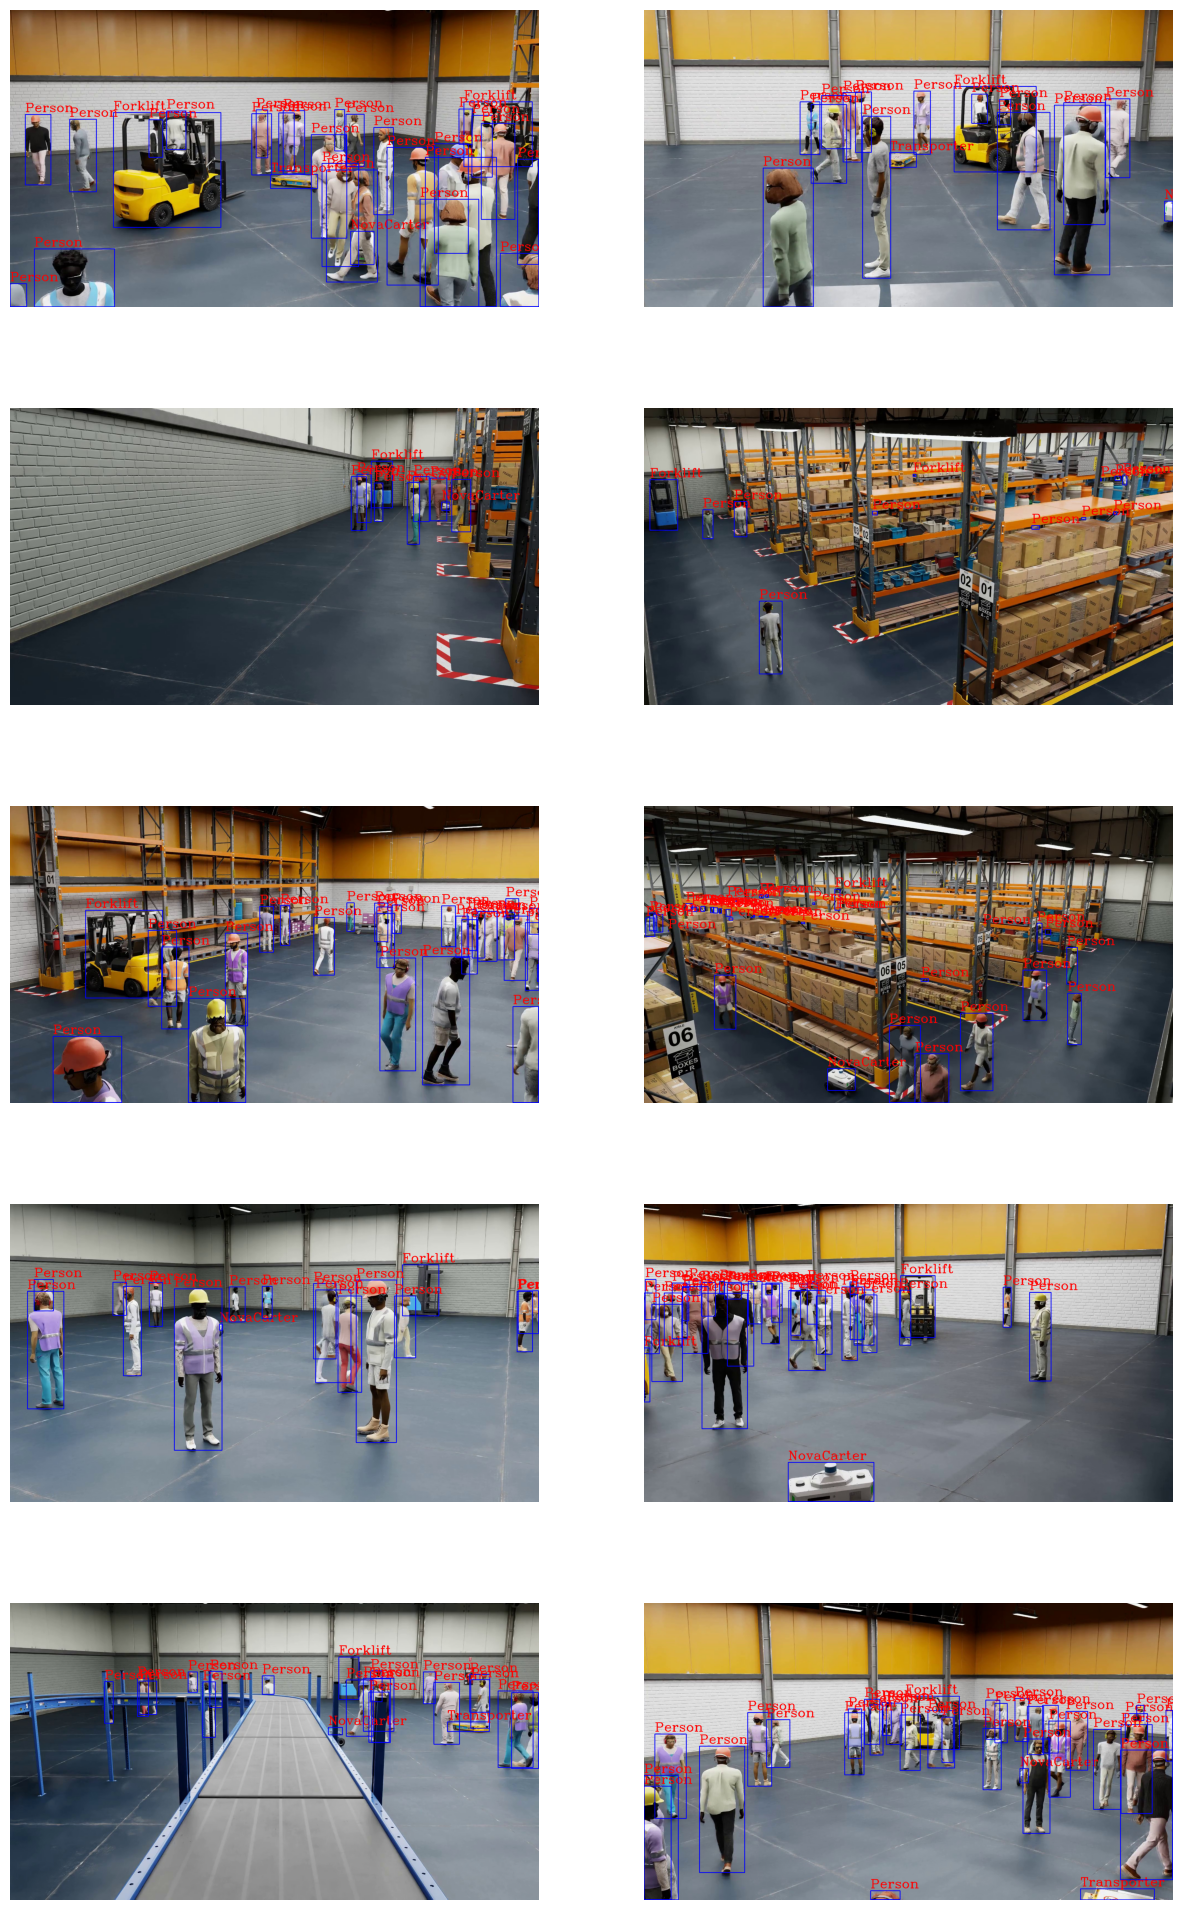

In [ ]:
plt.figure(figsize=(15,25))
images_path = sorted(os.listdir('/content/dataset/images/train'))
labels_path = sorted(os.listdir('/content/dataset/labels/train'))
class_list = ["Person","Forklift","NovaCarter","Transporter"]

random_number = np.random.randint(0, len(images_path), size=10)
for idx , n in enumerate(random_number):
  plt.subplot(5,2,idx+1)
  image = cv.imread(os.path.join('/content/dataset/images/train/' , images_path[n]))
  height , width = image.shape[:2]
  with open(os.path.join('/content/dataset/labels/train/',labels_path[n]), 'r') as f:
    for line in f:
      class_id, x, y, w, h = map(float, line.strip().split())
      x , y , w , h = x * width , y * height , w * width , h * height
      x1 , y1 , x2 , y2 = int(x - (w / 2)) , int(y - (h / 2)) , int(x + (w / 2)) , int(y + (h / 2))
      cv.rectangle(image , (x1, y1) , (x2, y2) , (255,0,0) , 2)
      cv.putText(image , class_list[int(class_id)] , (x1 , y1-10) , cv.FONT_HERSHEY_COMPLEX , 1.5 , (0,0,255) , 2)
  plt.imshow(cv.cvtColor(image , cv.COLOR_BGR2RGB)),plt.axis('off')


In [ ]:
data = {
    'train': '/content/dataset/images/train',
    'val': '/content/dataset/images/val',
    'nc': 4,
    'names': ["Person","Forklift","NovaCarter","Transporter"]
}

with open('/content/data.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False)

In [ ]:
model = YOLO('yolo11x.pt')

model.train(data='/content/data.yaml', epochs=100 , batch=6 , patience=50 , save_period=1 , project='/content/drive/MyDrive/YOLO_challenge_Training' , imgsz=(1920, 1080) , rect=True)

Ultralytics 8.3.151 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (NVIDIA A100-SXM4-40GB, 40507MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=6, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=(1920, 1080), int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11x.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=50, perspective=0.0, plots=True, pose=12.0

train: Scanning /content/dataset/labels/train.cache... 131100 images, 1556 backgrounds, 0 corrupt: 100%|██████████| 131100/131100 [00:00<?, ?it/s]

train: /content/dataset/images/train/091913.jpg: 1 duplicate labels removed


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
WARNING ⚠️ 'rect=True' is incompatible with DataLoader shuffle, setting shuffle=False
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1930.4±681.8 MB/s, size: 278.3 KB)


val: Scanning /content/dataset/labels/val.cache... 20100 images, 1153 backgrounds, 0 corrupt: 100%|██████████| 20100/20100 [00:00<?, ?it/s]


Plotting labels to /content/drive/MyDrive/YOLO_challenge_Training/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.000515625), 173 bias(decay=0.0)
Image sizes 1920 train, 1920 val
Using 8 dataloader workers
Logging results to /content/drive/MyDrive/YOLO_challenge_Training/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      29.8G     0.4891     0.4702     0.9242         87       1920: 100%|██████████| 21850/21850 [2:45:14<00:00,  2.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1675/1675 [08:13<00:00,  3.40it/s]


                   all      20100     188911      0.834      0.658       0.83      0.729

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      30.3G     0.5156     0.4222     0.9429         85       1920: 100%|██████████| 21850/21850 [2:40:06<00:00,  2.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1675/1675 [08:11<00:00,  3.41it/s]


                   all      20100     188911      0.817      0.827      0.934      0.816

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      30.3G     0.5583     0.5082     0.9748         84       1920: 100%|██████████| 21850/21850 [2:38:55<00:00,  2.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1675/1675 [08:08<00:00,  3.43it/s]


                   all      20100     188911      0.892      0.678      0.852      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      30.3G      0.552     0.5349     0.9756         86       1920: 100%|██████████| 21850/21850 [2:38:31<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1675/1675 [07:48<00:00,  3.57it/s]

                   all      20100     188911      0.613      0.277      0.461      0.411



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      30.2G     0.5805      0.503     0.9614         19       1920:  17%|█▋        | 3761/21850 [27:17<2:11:15,  2.30it/s]


KeyboardInterrupt: 

##extract frames and crop for re-id finetune

In [ ]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
detection_model = YOLO('detection_model.pt').to(device)

In [ ]:
save_train_images_dir = '/content/dataset/images/train'
os.makedirs(save_train_images_dir, exist_ok=True)

save_train_labels_dir = '/content/drive/MyDrive/labels/train'
os.makedirs(save_train_labels_dir, exist_ok=True)

save_val_images_dir = '/content/dataset/images/val'
os.makedirs(save_val_images_dir, exist_ok=True)

save_val_labels_dir = '/content/drive/MyDrive/labels/val'
os.makedirs(save_val_labels_dir, exist_ok=True)

train_dataset_path = (
    '/root/.cache/huggingface/hub/datasets--nvidia--PhysicalAI-SmartSpaces/snapshots/e7fca212e5e0aa1c4a036288ee80b0d51d0ef113/MTMC_Tracking_2025/train'
)

val_dataset_path = (
    '/root/.cache/huggingface/hub/datasets--nvidia--PhysicalAI-SmartSpaces/snapshots/6b88ca22a4b626a8835e47457f1c05b001fe00f7/MTMC_Tracking_2025/val')

camera_train_files_path = [
    os.path.join(train_dataset_path, f)
    for f in os.listdir(train_dataset_path)
    if os.path.isdir(os.path.join(train_dataset_path, f))
]

camera_val_files_path = [
    os.path.join(val_dataset_path, f)
    for f in os.listdir(val_dataset_path)
    if os.path.isdir(os.path.join(val_dataset_path, f))
]
class_list = ["Person","Forklift","NovaCarter","Transporter"]

def write_frame_and_label(args):
  label_path, labels = args
  with open(label_path, 'w') as f_lbl:
      f_lbl.write("\n".join(labels))

def process_camera(camera_path, save_labels_dir, detection_model, batch_size=6, io_procs=6):
  global image_counter

  ground_truth_path = os.path.join(camera_path, 'ground_truth.json')
  with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)

  videos_folder = os.path.join(camera_path, 'videos')
  video_files = [
      f for f in os.listdir(videos_folder)
      if f.lower().endswith(('.mp4', '.avi', '.mkv', '.MOV'))
  ]

  for cam_idx,video_fname in tqdm(enumerate(sorted(video_files))):
    camera_path = os.path.join(save_labels_dir , f"cam_{cam_idx}")
    os.makedirs(camera_path , exist_ok=True)
    vr = None
    try:
      vr = VideoReader(os.path.join(videos_folder, video_fname), ctx=gpu(0))
    except:
      vr = VideoReader(os.path.join(videos_folder, video_fname), ctx=cpu(0))

    total = len(vr)
    if total == 0:
      del vr
      continue

    try:
      fps = int(round(vr.get_avg_fps()))
    except:
      fps = 30

    sampled = list(range(0, total, fps))
    image_counter = 0

    for start in range(0, len(sampled), batch_size):
      batch_inds = sampled[start:start+batch_size]
      batch_frames = vr.get_batch(batch_inds).asnumpy()

      valid_frames = []
      valid_indices = []

      for i, frame in zip(batch_inds, batch_frames):
        if frame.shape[0] > 0 and frame.shape[1] > 0:
          valid_frames.append(frame)
          valid_indices.append(i)

      if not valid_frames:
        continue
      results = detection_model(valid_frames, batch=True, verbose=False)

      to_write = []
      for i, frame_np in enumerate(valid_frames):
        H, W = frame_np.shape[:2]

        lbl_path = os.path.join(camera_path, f"{image_counter}" + '.txt')

        labels = []
        for box in results[i].boxes:
          x, y, w, h = box.xywh[0]
          labels.append(
              f"{int(box.cls[0].cpu().numpy())} "
              f"{x/W:.6f} {y/H:.6f} {w/W:.6f} {h/H:.6f} "
              f"{box.conf[0].item():.2f}"
          )
        to_write.append((lbl_path, labels))
        image_counter += 1
      with Pool(processes=io_procs) as pool:
        pool.map(write_frame_and_label, to_write)

    del vr



for cam_idx, cam_path in enumerate(sorted(camera_train_files_path),start=11):
  out_img_dir = os.path.join(save_train_images_dir, str(cam_idx))
  out_lbl_dir = os.path.join(save_train_labels_dir, str(cam_idx))
  os.makedirs(out_img_dir, exist_ok=True)
  os.makedirs(out_lbl_dir, exist_ok=True)

  process_camera(
      cam_path,
      out_lbl_dir,
      detection_model,
  )

for cam_idx, cam_path in enumerate(sorted(camera_val_files_path),start=15):
  out_img_dir = os.path.join(save_val_images_dir, str(cam_idx))
  out_lbl_dir = os.path.join(save_val_labels_dir, str(cam_idx))
  os.makedirs(out_img_dir, exist_ok=True)
  os.makedirs(out_lbl_dir, exist_ok=True)

  process_camera(
      cam_path,
      out_lbl_dir,
      detection_model)

print('extracting frames completed...')

0it [00:00, ?it/s]

In [ ]:
image = cv.imread('/content/dataset/images/val/000100.jpg')
class_list = ["Person","Forklift","NovaCarter","Transporter"]
plt.figure(figsize=(15,15))
height , width = image.shape[:2]
with open(os.path.join('/content/drive/MyDrive/labels/val/Warehouse_015/cam_0/99.txt'), 'r') as f:
  for line in f:
    class_id, x, y, w, h , cls = map(float, line.strip().split())
    x , y , w , h = x * width , y * height , w * width , h * height
    x1 , y1 , x2 , y2 = int(x - (w / 2)) , int(y - (h / 2)) , int(x + (w / 2)) , int(y + (h / 2))
    cv.rectangle(image , (x1, y1) , (x2, y2) , (255,0,0) , 2)
    cv.putText(image , class_list[int(class_id)] , (x1 , y1-10) , cv.FONT_HERSHEY_COMPLEX , 1.5 , (0,0,255) , 2)
plt.imshow(cv.cvtColor(image , cv.COLOR_BGR2RGB)),plt.axis('off');

(<matplotlib.image.AxesImage at 0x7a52385f6010>,
 (np.float64(-0.5), np.float64(1919.5), np.float64(1079.5), np.float64(-0.5)))

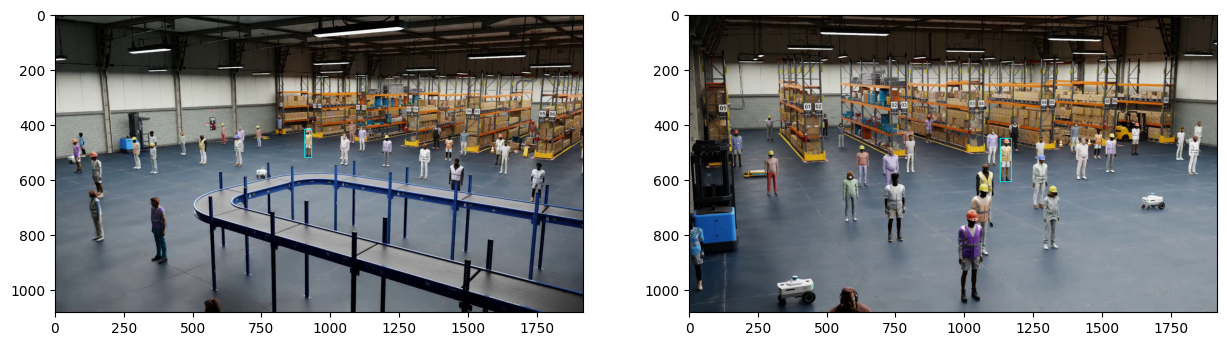

In [ ]:
plt.figure(figsize=(15,15))
#cam_0,10,
x1 , y1 , w1 , h1 = map(int,(906.53,418.91,25.81,101.54))
image_1 = cv.imread('/content/dataset/images/train/000001.jpg')
cv.rectangle(image_1 ,(x1,y1) , (x1+w1,y1+h1) , (255,255,0) , 2)
plt.subplot(1,2,1);plt.imshow(image_1[...,::-1])
#cam_1,10,
x2 , y2 , w2 , h2 = map(int,(1129.35,450.77,41.10,157.41))
image_2 = cv.imread('/content/dataset/images/train/000301.jpg')
cv.rectangle(image_2 ,(x2,y2) , (x2+w2,y2+h2) , (255,255,0) , 2)
plt.subplot(1,2,2);plt.imshow(image_2[...,::-1])

In [ ]:
H, W = 1080, 1920

def compute_iou(box1, box2):
  xa = max(box1[0], box2[0])
  ya = max(box1[1], box2[1])
  xb = min(box1[2], box2[2])
  yb = min(box1[3], box2[3])
  inter_width = max(0, xb - xa)
  inter_height = max(0, yb - ya)
  if inter_width <= 0 or inter_height <= 0:
    return 0.0
  inter_area = inter_width * inter_height

  box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
  box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
  union_area = box1_area + box2_area - inter_area
  return inter_area / union_area

def yolo2mot(detect_dir, out_text, iou_threshold=0.4):
  with open(out_text, 'w') as fout:
    for txt in sorted(glob.glob(f"{detect_dir}/*.txt")):
      frame_key = Path(txt).stem.split('_')[-1]
      gt_boxes = []
      if frame_key in ground_truth:
        for obj in ground_truth[frame_key]:
          camera_name = f"Camera_{int(detect_dir.split('/')[-1].split('_')[-1]):04d}"
          twoD_boxes = obj['2d bounding box visible']
          obj_id = obj['object id']
          if camera_name in twoD_boxes:
            bbox = twoD_boxes[camera_name]
            gt_boxes.append((bbox, obj_id))

      for line in open(txt):
        cls, xc, yc, w, h, conf = map(float, line.split())
        if conf < 0.2:
          continue

        xc, yc, w, h = xc * W, yc * H, w * W, h * H
        x1 = xc - w/2
        y1 = yc - h/2
        x2 = x1 + w
        y2 = y1 + h

        best_iou = 0.0
        best_id = -1
        for (gt_box, obj_id) in gt_boxes:
          iou_val = compute_iou([x1, y1, x2, y2], gt_box)
          if iou_val > best_iou:
            best_iou = iou_val
            best_id = obj_id

        if best_iou >= iou_threshold:
          assigned_id = best_id
        else:
          assigned_id = -1

        if assigned_id != -1:
          fout.write(f"{frame_key},{assigned_id},{x1:.2f},{y1:.2f},{w:.2f},{h:.2f},{conf:.2f},-1,-1,{int(cls)}\n")

train_labels_path = '/content/drive/MyDrive/labels/train'
val_labels_path = '/content/drive/MyDrive/labels/val'


for p in tqdm(os.listdir(train_labels_path)):
  camera_path = f'/root/.cache/huggingface/hub/datasets--nvidia--PhysicalAI-SmartSpaces/snapshots/6b88ca22a4b626a8835e47457f1c05b001fe00f7/MTMC_Tracking_2025/train/Warehouse_{int(p):03d}'
  ground_truth_path = os.path.join(camera_path, 'ground_truth.json')
  with open(ground_truth_path, 'r') as f:
    ground_truth = json.load(f)
  for c in os.listdir(os.path.join(train_labels_path,p)):
    os.makedirs(f"/content/drive/MyDrive/MOT_labels/train/place_{p}", exist_ok=True)
    yolo2mot(f"/content/drive/MyDrive/labels/train/{p}/{c}",
            f"/content/drive/MyDrive/MOT_labels/train/place_{p}/{c}.txt")

for p in tqdm(os.listdir(val_labels_path)):
  for c in os.listdir(os.path.join(val_labels_path,p)):
    os.makedirs(f"/content/drive/MyDrive/MOT_labels/val/place_{p}", exist_ok=True)
    yolo2mot(f"/content/drive/MyDrive/labels/val/{p}/{c}",
            f"/content/drive/MyDrive/MOT_labels/val/place_{p}/{c}.txt")


In [ ]:
frames_dir = '/content/dataset/images/train'
frames = sorted(os.listdir(frames_dir))


def crop_and_save(scene, cam, det_txt, frames_dir, out_dir):
  global frames
  dir = os.path.join(out_dir,scene)
  os.makedirs(dir,exist_ok=True)
  frames_for_use = frames[:300]
  frames = frames[300:]

  dets = {}
  for line in open(det_txt):
    f , obj_id , x1 , y1 , w , h , conf , *_ , cls = line.split(',')
    f = int(f)
    obj_id = int(obj_id)
    cls = int(cls)
    bbox = (float(x1), float(y1), float(w), float(h))
    dets.setdefault(f, []).append((bbox,cls,obj_id))

  for frame , items in dets.items():
    image = cv.imread(f"{frames_dir}/{frames_for_use[frame]}")
    for i , ((x1, y1, w, h),cls, obj_id) in enumerate(items):
      crop = image[int(y1):int(y1+h),int(x1):int(x1+w)]

      id_dir = f"{dir}/{obj_id:04d}"
      os.makedirs(id_dir, exist_ok=True)
      out_name = f"{scene}_{cam}_{frame:06d}_{i}_{cls}.jpg"
      cv.imwrite(f"{id_dir}/{out_name}", crop)


train_mot_labels_dir = '/content/drive/MyDrive/MOT_labels/train'
z = 0
for a in sorted(os.listdir(train_mot_labels_dir),key=lambda x: int(x.split('_')[1])):
  place_dir = os.path.join(train_mot_labels_dir,a)
  for b in tqdm(sorted(os.listdir(place_dir),key=lambda x: int(x.split('_')[1].split('.')[0]))):
    cam_text_path = os.path.join(place_dir,b)
    crop_and_save(f"{a}",f"{b.split('.')[0]}",
                  cam_text_path,
                  frames_dir,
                  '/content/drive/MyDrive/reid_data/train')
  break


100%|██████████| 25/25 [06:05<00:00, 14.60s/it]


# transreid_ssl

In [ ]:
!git clone https://github.com/damo-cv/TransReID-SSL.git

Cloning into 'TransReID-SSL'...
remote: Enumerating objects: 151, done.
remote: Total 151 (delta 0), reused 0 (delta 0), pack-reused 151 (from 1)
Receiving objects: 100% (151/151), 135.46 KiB | 19.35 MiB/s, done.
Resolving deltas: 100% (28/28), done.


In [ ]:
cd TransReID-SSL

/content/TransReID-SSL


In [ ]:
pip install -r requirements.txt

  Using cached lmdb-1.7.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (1.3 kB)
  Using cached metric_learn-0.7.0-py2.py3-none-any.whl.metadata (5.2 kB)
  Using cached pytorch_ignite-0.5.2-py3-none-any.whl.metadata (27 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 116.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
pip install ruamel.yaml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 35.8 MB/s eta 0:00:00


In [ ]:
yaml_file_path = "/content/TransReID-SSL/transreid_pytorch/configs/market/vit_base_ics_384.yml"

new_pretrain_path = "/content/TransReID-SSL/transreid_pytorch/model/vit_base_ics_cfs_lup.pth"
new_output_dir = "/content/TransReID-SSL/transreid_pytorch/logs/test_without_finetune"
os.makedirs(new_output_dir,exist_ok=True)

yaml = ruamel.yaml.YAML()
yaml.preserve_quotes = True
yaml.indent(mapping=2, sequence=4, offset=2)

with open(yaml_file_path, 'r') as file:
    config = yaml.load(file)

if 'MODEL' in config and 'PRETRAIN_PATH' in config['MODEL']:
    config['MODEL']['PRETRAIN_PATH'] = new_pretrain_path

if 'OUTPUT_DIR' in config:
    config['OUTPUT_DIR'] = new_output_dir

if 'DATASETS' in config and 'ROOT_DIR' in config['DATASETS']:
    config['DATASETS']['ROOT_DIR'] = "('/content')"

if 'SOLVER' in config and 'CHECKPOINT_PERIOD' in config['SOLVER']:
    config['SOLVER']['CHECKPOINT_PERIOD'] = 1

if 'MODEL' in config and 'DEVICE_ID' in config['MODEL']:
    config['MODEL']['DEVICE_ID'] = "('0')"


with open(yaml_file_path, 'w') as file:
    yaml.dump(config, file)

In [ ]:
!cp -r /content/drive/MyDrive/market1501.zip /content

In [ ]:
!cp -r /content/drive/MyDrive/vit_base_ics_cfs_lup.pth /content/TransReID-SSL/transreid_pytorch/model

cp: cannot create regular file '/content/TransReID-SSL/transreid_pytorch/model': No such file or directory


In [ ]:
!unzip /content/market1501.zip -d /content

Archive:  /content/market1501.zip
   creating: /content/market1501/
  inflating: /content/market1501/.DS_Store  
  inflating: /content/__MACOSX/market1501/._.DS_Store  
   creating: /content/market1501/bounding_box_test/
   creating: /content/market1501/bounding_box_train/
   creating: /content/market1501/query/
  inflating: /content/market1501/bounding_box_test/0026_c4.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0026_c4.jpg  
  inflating: /content/market1501/bounding_box_test/0002_c12.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0002_c12.jpg  
  inflating: /content/market1501/bounding_box_test/0025_c15.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0025_c15.jpg  
  inflating: /content/market1501/bounding_box_test/0012_c1.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0012_c1.jpg  
  inflating: /content/market1501/bounding_box_test/0024_c14.jpg  
  inflating: /content/__MACOSX/market1501/bounding_b

In [ ]:
cd transreid_pytorch

/content/TransReID-SSL/transreid_pytorch


In [ ]:
!python train.py --config_file configs/market/vit_base_ics_384.yml

2025-08-08 21:10:02 transreid INFO: Saving model in the path :/content/TransReID-SSL/transreid_pytorch/logs/test_without_finetune
2025-08-08 21:10:02 transreid INFO: Loaded configuration file configs/market/vit_base_ics_384.yml
2025-08-08 21:10:02 transreid INFO: Running with config:
DATALOADER:
  NUM_INSTANCE: 4
  NUM_WORKERS: 8
  REMOVE_TAIL: 0
  SAMPLER: softmax_triplet
DATASETS:
  NAMES: market1501
  ROOT_DIR: /content
  ROOT_TRAIN_DIR: ../data
  ROOT_VAL_DIR: ../data
INPUT:
  PADDING: 10
  PIXEL_MEAN: [0.5, 0.5, 0.5]
  PIXEL_STD: [0.5, 0.5, 0.5]
  PROB: 0.5
  RE_PROB: 0.5
  SIZE_TEST: [384, 128]
  SIZE_TRAIN: [384, 128]
MODEL:
  ATT_DROP_RATE: 0.0
  COS_LAYER: False
  DEVICE: cuda
  DEVICE_ID: 3
  DEVIDE_LENGTH: 4
  DIST_TRAIN: False
  DROPOUT_RATE: 0.0
  DROP_OUT: 0.0
  DROP_PATH: 0.1
  FEAT_DIM: 512
  GEM_POOLING: False
  ID_LOSS_TYPE: softmax
  ID_LOSS_WEIGHT: 1.0
  IF_LABELSMOOTH: off
  IF_WITH_CENTER: no
  JPM: False
  LAST_STRIDE: 1
  METRIC_LOSS_TYPE: triplet
  NAME: transf

In [ ]:
!cp -r  /content/drive/MyDrive/TransReID-SSL /content

In [ ]:
cd TransReID-SSL

/content/TransReID-SSL


In [ ]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.6/299.6 kB 14.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 79.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 60.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
!cp -r /content/drive/MyDrive/market1501.zip /content

In [ ]:
!unzip /content/market1501.zip -d /content

Archive:  /content/market1501.zip
   creating: /content/market1501/
  inflating: /content/market1501/.DS_Store  
  inflating: /content/__MACOSX/market1501/._.DS_Store  
   creating: /content/market1501/bounding_box_test/
   creating: /content/market1501/bounding_box_train/
   creating: /content/market1501/query/
  inflating: /content/market1501/bounding_box_test/0047_c2.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0047_c2.jpg  
  inflating: /content/market1501/bounding_box_test/0046_c12.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0046_c12.jpg  
  inflating: /content/market1501/bounding_box_test/0045_c7.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0045_c7.jpg  
  inflating: /content/market1501/bounding_box_test/0038_c7.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_test/._0038_c7.jpg  
  inflating: /content/market1501/bounding_box_test/0038_c6.jpg  
  inflating: /content/__MACOSX/market1501/bounding_box_

In [ ]:
cd transreid_pytorch

/content/TransReID-SSL/transreid_pytorch


In [ ]:
!python train.py --config_file configs/market/vit_base_ics_384.yml

2025-08-17 21:13:15 transreid INFO: Saving model in the path :/content/TransReID-SSL/transreid_pytorch/logs/test_without_finetune
2025-08-17 21:13:15 transreid INFO: Loaded configuration file configs/market/vit_base_ics_384.yml
2025-08-17 21:13:15 transreid INFO: Running with config:
DATALOADER:
  NUM_INSTANCE: 4
  NUM_WORKERS: 8
  REMOVE_TAIL: 0
  SAMPLER: softmax_triplet
DATASETS:
  NAMES: market1501
  ROOT_DIR: /content
  ROOT_TRAIN_DIR: ../data
  ROOT_VAL_DIR: ../data
INPUT:
  PADDING: 10
  PIXEL_MEAN: [0.5, 0.5, 0.5]
  PIXEL_STD: [0.5, 0.5, 0.5]
  PROB: 0.5
  RE_PROB: 0.5
  SIZE_TEST: [384, 128]
  SIZE_TRAIN: [384, 128]
MODEL:
  ATT_DROP_RATE: 0.0
  COS_LAYER: False
  DEVICE: cuda
  DEVICE_ID: 0
  DEVIDE_LENGTH: 4
  DIST_TRAIN: False
  DROPOUT_RATE: 0.0
  DROP_OUT: 0.0
  DROP_PATH: 0.1
  FEAT_DIM: 512
  GEM_POOLING: False
  ID_LOSS_TYPE: softmax
  ID_LOSS_WEIGHT: 1.0
  IF_LABELSMOOTH: off
  IF_WITH_CENTER: no
  JPM: False
  LAST_STRIDE: 1
  METRIC_LOSS_TYPE: triplet
  NAME: transf

In [ ]:
!cp /content/TransReID-SSL/transreid_pytorch/logs/test_without_finetune/transformer_56.pth /content/drive/MyDrive/

In [ ]:
!python test.py --config_file configs/market/vit_base_ics_384.yml MODEL.DEVICE_ID "('0')"  TEST.WEIGHT 'logs/test_without_finetune/transformer_56.pth'

2025-08-17 22:00:49 transreid INFO: Namespace(config_file='configs/market/vit_base_ics_384.yml', opts=['MODEL.DEVICE_ID', "('0')", 'TEST.WEIGHT', 'logs/test_without_finetune/transformer_56.pth'])
2025-08-17 22:00:49 transreid INFO: Loaded configuration file configs/market/vit_base_ics_384.yml
2025-08-17 22:00:49 transreid INFO: 
MODEL:
  PRETRAIN_PATH: '/content/TransReID-SSL/transreid_pytorch/model/vit_base_ics_cfs_lup.pth'
  PRETRAIN_HW_RATIO: 2
  METRIC_LOSS_TYPE: 'triplet'
  IF_LABELSMOOTH: 'off'
  IF_WITH_CENTER: 'no'
  NAME: 'transformer'
  NO_MARGIN: true
  DEVICE_ID: ('0')
  TRANSFORMER_TYPE: 'vit_base_patch16_224_TransReID'
  STRIDE_SIZE: [16, 16]
  STEM_CONV: true # False for vanilla ViT-S
  # DIST_TRAIN: True

INPUT:
  SIZE_TRAIN: [384, 128]
  SIZE_TEST: [384, 128]
  PROB: 0.5 # random horizontal flip
  RE_PROB: 0.5 # random erasing
  PADDING: 10
  PIXEL_MEAN: [0.5, 0.5, 0.5]
  PIXEL_STD: [0.5, 0.5, 0.5]

DATASETS:
  NAMES: ('market1501')
  ROOT_DIR: ('/content')

DATALOADER

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

download_list = ['videos' , 'calibration.json' , 'ground_truth.json']

for j in tqdm([0]):
  for i in download_list:
    snapshot_download(
      repo_id="nvidia/PhysicalAI-SmartSpaces",
      repo_type="dataset",
      local_dir="/content/hf_datasets",
      allow_patterns=[f"MTMC_Tracking_2025/train/Warehouse_{j:03d}/{i}*"]
    )

  0%|          | 0/1 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Fetching 25 files:   0%|          | 0/25 [00:00<?, ?it/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/160M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/82.6M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/145M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/170M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/160M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/120M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/176M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/171M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/91.3M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/150M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/102M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/155M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/117M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/165M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/148M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/103M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/124M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/161M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/139M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/113M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/132M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/128M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/133M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/162M [00:00<?, ?B/s]

MTMC_Tracking_2025/train/Warehouse_000/v(…):   0%|          | 0.00/155M [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

MTMC_Tracking_2025/train/Warehouse_000/c(…):   0%|          | 0.00/81.4k [00:00<?, ?B/s]

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

MTMC_Tracking_2025/train/Warehouse_000/g(…):   0%|          | 0.00/328M [00:00<?, ?B/s]

100%|██████████| 1/1 [00:56<00:00, 56.46s/it]


In [ ]:
max_frames = 600
os.makedirs('depth_maps', exist_ok=True)

for j in tqdm(range(25)):
    local_file = hf_hub_download(
        repo_id="nvidia/PhysicalAI-SmartSpaces",
        repo_type="dataset",
        filename=f"MTMC_Tracking_2025/train/Warehouse_000/depth_maps/Camera_{j:04d}.h5",
        local_dir="/content/hf_datasets"
    )

    src = local_file
    dst = f'/content/depth_maps/Camera_{j:04d}_30.h5'

    with h5py.File(src, "r") as f, h5py.File(dst, "w") as f_new:
        keys = list(f.keys())[:max_frames]

        for key in keys:
            data = f[key][()]
            f_new.create_dataset(key, data=data, compression="gzip", compression_opts=1)

    os.remove(src)


  0%|          | 0/25 [00:00<?, ?it/s]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/13.0G [00:00<?, ?B/s]

  4%|▍         | 1/25 [03:02<1:12:58, 182.45s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/12.7G [00:00<?, ?B/s]

  8%|▊         | 2/25 [06:46<1:19:16, 206.81s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/14.4G [00:00<?, ?B/s]

 12%|█▏        | 3/25 [11:02<1:24:02, 229.21s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/12.6G [00:00<?, ?B/s]

 16%|█▌        | 4/25 [15:27<1:25:12, 243.47s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/6.18G [00:00<?, ?B/s]

 20%|██        | 5/25 [18:00<1:10:16, 210.83s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/3.67G [00:00<?, ?B/s]

 24%|██▍       | 6/25 [19:27<53:24, 168.67s/it]  

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/1.97G [00:00<?, ?B/s]

 28%|██▊       | 7/25 [20:13<38:33, 128.52s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/11.1G [00:00<?, ?B/s]

 32%|███▏      | 8/25 [23:28<42:26, 149.80s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/6.45G [00:00<?, ?B/s]

 36%|███▌      | 9/25 [25:37<38:12, 143.31s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/8.19G [00:00<?, ?B/s]

 40%|████      | 10/25 [28:47<39:27, 157.84s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/7.18G [00:00<?, ?B/s]

 44%|████▍     | 11/25 [31:28<37:01, 158.71s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/8.47G [00:00<?, ?B/s]

 48%|████▊     | 12/25 [34:45<36:53, 170.28s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/7.31G [00:00<?, ?B/s]

 52%|█████▏    | 13/25 [37:15<32:48, 164.07s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/6.01G [00:00<?, ?B/s]

 56%|█████▌    | 14/25 [39:39<28:59, 158.17s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/9.14G [00:00<?, ?B/s]

 60%|██████    | 15/25 [42:35<27:16, 163.64s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/4.06G [00:00<?, ?B/s]

 64%|██████▍   | 16/25 [43:58<20:53, 139.32s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/7.42G [00:00<?, ?B/s]

 68%|██████▊   | 17/25 [45:44<17:13, 129.24s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/5.28G [00:00<?, ?B/s]

 72%|███████▏  | 18/25 [47:23<14:00, 120.10s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/8.92G [00:00<?, ?B/s]

 76%|███████▌  | 19/25 [49:51<12:50, 128.44s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/5.18G [00:00<?, ?B/s]

 80%|████████  | 20/25 [51:19<09:41, 116.32s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/7.67G [00:00<?, ?B/s]

 84%|████████▍ | 21/25 [53:26<07:58, 119.60s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/8.63G [00:00<?, ?B/s]

 88%|████████▊ | 22/25 [56:02<06:31, 130.59s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/6.60G [00:00<?, ?B/s]

 92%|█████████▏| 23/25 [57:46<04:04, 122.40s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/9.88G [00:00<?, ?B/s]

 96%|█████████▌| 24/25 [1:00:12<02:09, 129.53s/it]

MTMC_Tracking_2025/train/Warehouse_000/d(…):   0%|          | 0.00/6.46G [00:00<?, ?B/s]

100%|██████████| 25/25 [1:02:07<00:00, 149.10s/it]


In [ ]:
os.remove('/content/hf_datasets/MTMC_Tracking_2025/train/Warehouse_000/videos/Camera_0005.mp4')

In [ ]:
cd drive/MyDrive/TransReID-SSL

/content/drive/MyDrive/TransReID-SSL


In [ ]:
pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 303.0/303.0 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 10.2 MB/s eta 0:00:00


In [ ]:
cd transreid_pytorch

/content/drive/MyDrive/TransReID-SSL/transreid_pytorch


In [ ]:
pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 28.7 MB/s eta 0:00:00


In [ ]:
from model.make_model import make_model
from config.defaults import _C

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
detection_model = YOLO('/content/drive/MyDrive/detection_model.pt').to(device)


In [ ]:
yaml_file_path = "/content/drive/MyDrive/TransReID-SSL/transreid_pytorch/configs/market/vit_base_ics_384_custom.yml"

new_pretrain_path = "/content/drive/MyDrive/TransReID-SSL/transreid_pytorch/model/vit_base_ics_cfs_lup.pth"
new_output_dir = "/content/test_without_finetune"

yaml = ruamel.yaml.YAML()
yaml.preserve_quotes = True
yaml.indent(mapping=2, sequence=4, offset=2)

with open(yaml_file_path, 'r') as file:
    config = yaml.load(file)

if 'MODEL' in config and 'PRETRAIN_PATH' in config['MODEL']:
    config['MODEL']['PRETRAIN_PATH'] = new_pretrain_path

if 'OUTPUT_DIR' in config:
    config['OUTPUT_DIR'] = new_output_dir

if 'DATASETS' in config and 'NAMES' in config['DATASETS']:
    config['DATASETS']['NAMES'] = "('market1501')"
else:
    print('dataset in not in config file')

if 'DATASETS' in config and 'ROOT_DIR' in config['DATASETS']:
    config['DATASETS']['ROOT_DIR'] = "('/Users/matin/Documents/challenge')"

with open(yaml_file_path, 'w') as file:
    yaml.dump(config, file)

In [ ]:
ckpt_path = "/content/drive/MyDrive/TransReID-SSL/transreid_pytorch/model/transformer_49.pth"
cfg_path  = "/content/drive/MyDrive/TransReID-SSL/transreid_pytorch/configs/market/vit_base_ics_384_custom.yml"
num_class = 38
camera_num = 10
view_num = 0

cfg = _C.clone()
cfg.merge_from_file(cfg_path)
model = make_model(cfg, num_class=num_class, camera_num=camera_num, view_num=view_num)
model.cpu()

ck = torch.load(ckpt_path, map_location='cpu')
state_dict = ck.get('state_dict', ck.get('model', ck))

if isinstance(state_dict, dict) and 'state_dict' in state_dict:
    state_dict = state_dict['state_dict']

def strip_module(k):
    return k[len('module.'):] if k.startswith('module.') else k

sd1 = {strip_module(k): v for k, v in state_dict.items()}

model_keys = list(model.state_dict().keys())
ck_has_base = any(k.startswith('base.') for k in sd1.keys())
model_has_base = any(k.startswith('base.') for k in model_keys)

if model_has_base and not ck_has_base:
    sd2 = {'base.' + k: v for k, v in sd1.items()}
elif ck_has_base and not model_has_base:
    sd2 = {k[len('base.'):] if k.startswith('base.') else k: v for k, v in sd1.items()}
else:
    sd2 = sd1

m_sd = model.state_dict()
sd_load = {}
skipped = []
for k, v in sd2.items():
    if k in m_sd:
        if v.shape == m_sd[k].shape:
            sd_load[k] = v
        else:
            skipped.append((k, v.shape, m_sd[k].shape))

print(f"model keys: {len(m_sd)}, ckpt keys(after normalize): {len(sd2)}, to load: {len(sd_load)}")
print("examples keys to be loaded:", list(sd_load.keys())[:10])
print("skipped due to shape mismatch (examples):", skipped[:6])

res = model.load_state_dict(sd_load, strict=False)
pprint.pprint(res)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
print("Model ready.")


using Transformer_type: vit_base_patch16_224_TransReID as a backbone
using stride: [16, 16], and patch number is num_y24 * num_x8
Resized position embedding from size:torch.Size([1, 129, 768]) to size: torch.Size([1, 193, 768]) with height:24 width: 8
Load 172 / 174 layers.
Loading pretrained ImageNet model......from /content/drive/MyDrive/TransReID-SSL/transreid_pytorch/model/vit_base_ics_cfs_lup.pth
===========building transformer===========
model keys: 180, ckpt keys(after normalize): 180, to load: 180
examples keys to be loaded: ['base.cls_token', 'base.pos_embed', 'base.patch_embed.conv.0.weight', 'base.patch_embed.conv.1.IN.weight', 'base.patch_embed.conv.1.IN.bias', 'base.patch_embed.conv.1.BN.weight', 'base.patch_embed.conv.1.BN.bias', 'base.patch_embed.conv.1.BN.running_mean', 'base.patch_embed.conv.1.BN.running_var', 'base.patch_embed.conv.1.BN.num_batches_tracked']
skipped due to shape mismatch (examples): []
<All keys matched successfully>
Model ready.


In [ ]:
transform = transforms.Compose([
    transforms.Resize((384, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


gallery_dir = '/content/drive/MyDrive/market1501/gallery'
gallery_images = [os.path.join(gallery_dir,image) for image in sorted(os.listdir(gallery_dir)) if image.lower().endswith('jpg')]
gallery_ids = [os.path.basename(p).split('_')[0] for p in gallery_images]

gallery_features = []
with torch.no_grad():
    for image_path in gallery_images:
        image = Image.open(image_path).convert('RGB')
        image_tensor = transform(image).unsqueeze(0).to(device)
        feat = model(image_tensor)
        feat = F.normalize(feat, dim=1)
        gallery_features.append(feat)

gallery_features = torch.cat(gallery_features , dim=0)
gallery_features = gallery_features.float()

In [ ]:
def load_camera_matrices(intrinsic, extrinsic):
    """
    Load camera matrices from intrinsic and extrinsic parameters.
    Returns:
      K     : Intrinsic matrix
      K_inv : Inverse intrinsic matrix
      R     : Rotation matrix
      t     : Translation vector
      R_inv : Inverse of rotation
    """
    K = np.array(intrinsic, dtype=float)
    E = np.array(extrinsic, dtype=float)
    R = E[:, :3]                       # rotation
    t = E[:, 3].reshape((3,1))         # translation
    R_inv = np.linalg.inv(R)
    K_inv = np.linalg.inv(K)
    return K, K_inv, R, t, R_inv


def bilinear_sample(image, x, y):
    """
    Bilinear sampling of a 2D image at float coordinates (x,y).
    If (x,y) is outside image → return NaN.
    """
    H, W = image.shape
    if x < 0 or x > W - 1 or y < 0 or y > H - 1:
        return float('nan')

    # nearest integer coords
    x0 = int(math.floor(x)); x1 = min(x0 + 1, W-1)
    y0 = int(math.floor(y)); y1 = min(y0 + 1, H-1)

    # corner values
    Ia = image[y0, x0]
    Ib = image[y0, x1]
    Ic = image[y1, x0]
    Id = image[y1, x1]

    vals = np.array([Ia, Ib, Ic, Id], dtype=np.float64)

    # interpolation weights
    weights = np.array([
        (x1-x)*(y1-y),
        (x-x0)*(y1-y),
        (x1-x)*(y-y0),
        (x-x0)*(y-y0)
    ], dtype=np.float64)

    # mask invalid
    mask = np.isfinite(vals) & (vals > 0)
    if not np.any(mask):
        return float('nan')

    weights = weights * mask
    wsum = weights.sum()
    if wsum <= 0:
        return float('nan')

    return float((vals * weights).sum() / wsum)


def sample_depth_improved(depth_map, u, v, window=1, max_radius=5):
    """
    Sample a depth value from depth_map at pixel (u,v).
    1. Search in a small window (bilinear interpolation).
    2. If not found, expand search radius outward up to max_radius.
    3. Returns median of valid depth values.
    """
    H, W = depth_map.shape
    vals = []

    # step 1: search in local window
    for dy in range(-window, window+1):
        for dx in range(-window, window+1):
            sx = u + dx
            sy = v + dy
            d = bilinear_sample(depth_map, sx, sy)
            if np.isfinite(d) and d > 0:
                vals.append(d)
    if len(vals) > 0:
        return float(np.median(vals))

    # step 2: expand search radius
    for r in range(1, max_radius+1):
        xs = np.arange(int(math.floor(u-r)), int(math.floor(u+r))+1)
        ys = np.arange(int(math.floor(v-r)), int(math.floor(v+r))+1)

        # top/bottom edges
        for x_ in xs:
            for y_ in (int(math.floor(v-r)), int(math.floor(v+r))):
                if x_ < 0 or x_ > W-1 or y_ < 0 or y_ > H-1:
                    continue
                d = bilinear_sample(depth_map, x_, y_)
                if np.isfinite(d) and d > 0:
                    vals.append(d)

        # left/right edges
        for y_ in ys[1:-1]:
            for x_ in (int(math.floor(u-r)), int(math.floor(u+r))):
                if x_ < 0 or x_ > W-1 or y_ < 0 or y_ > H-1:
                    continue
                d = bilinear_sample(depth_map, x_, y_)
                if np.isfinite(d) and d > 0:
                    vals.append(d)

        if len(vals) > 0:
            return float(np.median(vals))

    return None


def pixel_to_world(u, v, Z_cam, K_inv, R_inv, t):
    """
    Convert pixel (u,v) with camera depth Z_cam into world coordinates.
    """
    p = np.array([u, v, 1.0], dtype=np.float64).reshape(3,1)
    x_cam = Z_cam * (K_inv @ p)          # camera coordinates
    Xw = R_inv @ (x_cam - t)             # world coordinates
    return Xw.flatten()


def process_bboxes(bboxes, depth_map, K, K_inv, R, t, R_inv,
                   sample_fn=sample_depth_improved,
                   depth_window=1, max_radius=5,
                   x_fracs=None, y_frac=0.95,
                   min_valid_points=3,
                   max_valid_depth=None):
    """
    Process bounding boxes → extract 3D world coordinates.

    Args:
      bboxes     : list of bounding boxes (x1,y1,x2,y2)
      depth_map  : depth image
      K, K_inv   : intrinsic matrices
      R, t, R_inv: extrinsic (rotation, translation)
      sample_fn  : depth sampling function
      depth_window: local window size for sampling
      max_radius : max radius for expansion if no depth
      x_fracs    : x fractions inside bbox for sampling points
      y_frac     : y fraction (vertical) inside bbox
      min_valid_points: minimum required points to compute 3D
      max_valid_depth : optional cutoff

    Returns:
      rows: list of dictionaries with bbox + world coords
    """
    # normalize input: single bbox → wrap in list
    if isinstance(bboxes, (tuple, list)) and len(bboxes)==4 and not isinstance(bboxes[0], (list, tuple)):
        bboxes = [tuple(map(int, bboxes))]
    rows = []

    H, W = depth_map.shape

    if x_fracs is None:
        # 7 sample points across width of bbox
        x_fracs = np.linspace(0.12, 0.88, 7)

    for idx, (x1, y1, x2, y2) in enumerate(bboxes):
        x1_i, y1_i, x2_i, y2_i = int(x1), int(y1), int(x2), int(y2)
        crop_w = max(1, x2_i - x1_i)
        crop_h = max(1, y2_i - y1_i)

        # candidate pixel positions inside bbox
        points = []
        for xf in x_fracs:
            u = x1_i + xf * crop_w
            v = y1_i + y_frac * crop_h
            points.append((float(u), float(v)))

        per_point = []     # store sampled pixel + depth
        valid_world = []   # valid 3D world points
        valid_depths = []  # valid depth values

        # sample depth for each candidate point
        for (u, v) in points:
            d = None
            if sample_fn is not None:
                try:
                    d = sample_fn(depth_map, u, v, window=depth_window, max_radius=max_radius)
                except TypeError:
                    d = sample_fn(depth_map, u, v, window=depth_window)
                except Exception:
                    d = None

            # fallback: nearest pixel
            if d is None or not np.isfinite(d) or d <= 0:
                iu = int(np.clip(int(round(u)), 0, W-1))
                iv = int(np.clip(int(round(v)), 0, H-1))
                val = depth_map[iv, iu]
                if np.isfinite(val) and val > 0:
                    d = float(val)

            # optional cutoff
            if d is not None and max_valid_depth is not None:
                if d > max_valid_depth:
                    d = None

            per_point.append((int(round(u)), int(round(v)), None if d is None else float(d)))

            # valid → convert to world coords
            if d is not None and np.isfinite(d) and d > 0:
                Xw, Yw, Zw = pixel_to_world(u, v, float(d), K_inv, R_inv, t)
                valid_world.append((float(Xw), float(Yw), float(Zw)))
                valid_depths.append(float(d))

        # -------------------------------------------------------
        # If too few valid points → fallback using bbox center
        # -------------------------------------------------------
        if len(valid_world) < min_valid_points:
            mid_u = float(x1_i + crop_w / 2.0)
            mid_v = float(y2_i)
            mid_d = None
            if sample_fn is not None:
                try:
                    mid_d = sample_fn(depth_map, mid_u, mid_v, window=depth_window, max_radius=max_radius)
                except TypeError:
                    mid_d = sample_fn(depth_map, mid_u, mid_v, window=depth_window)
                except Exception:
                    mid_d = None
            if mid_d is None or not np.isfinite(mid_d) or mid_d <= 0:
                iu = int(np.clip(int(round(mid_u)), 0, W-1))
                iv = int(np.clip(int(round(mid_v)), 0, H-1))
                val = depth_map[iv, iu]
                if np.isfinite(val) and val > 0:
                    mid_d = float(val)
            if mid_d is None:
                continue
            Xw, Yw, Zw = pixel_to_world(mid_u, mid_v, float(mid_d), K_inv, R_inv, t)
            rows.append({
                'bbox_id': idx, 'x1': x1_i, 'y1': y1_i, 'x2': x2_i, 'y2': y2_i,
                'pixel_u': int(round(mid_u)), 'pixel_v': int(round(mid_v)),
                'Z_cam': float(mid_d),
                'X_world': float(Xw), 'Y_world': float(Yw), 'Z_world': float(Zw),
                'per_point': per_point,
                'median_depth': float(mid_d),
                'method': 'fallback_mid',
                'num_valid_points': len(valid_world)
            })
            continue

        # -------------------------------------------------------
        # Otherwise use median of all valid world points
        # -------------------------------------------------------
        arr = np.array(valid_world, dtype=np.float64)
        Xm = float(np.median(arr[:,0]))
        Ym = float(np.median(arr[:,1]))
        Zm = float(np.median(arr[:,2]))

        frac_valid = float(len(valid_world)) / float(len(points))
        z_std = float(np.std(arr[:,2])) if arr.shape[0] > 0 else float('inf')

        rows.append({
            'bbox_id': idx, 'x1': x1_i, 'y1': y1_i, 'x2': x2_i, 'y2': y2_i,
            'pixel_u': None, 'pixel_v': None,
            'Z_cam': float(Zm),
            'X_world': float(Xm), 'Y_world': float(Ym), 'Z_world': float(Zm),
            'per_point': per_point,
            'median_depth': float(Zm),
            'method': 'median_world',
            'num_valid_points': len(valid_world),
            'frac_valid': frac_valid,
            'z_std': z_std
        })

    return rows


In [ ]:
with open('/content/hf_datasets/MTMC_Tracking_2025/train/Warehouse_000/calibration.json' , 'r') as f:
    camera_calibrations = json.load(f)['sensors']

calibration_dict = {}
for i in camera_calibrations:
    calibration_dict[i['id']] = {'intrinsicMatrix' : i['intrinsicMatrix'] , 'extrinsicMatrix' : i['extrinsicMatrix']}

In [ ]:
# -------------------------------------------------------
# Load ground truth data (json file containing 3D locations)
# -------------------------------------------------------
with open('/content/hf_datasets/MTMC_Tracking_2025/train/Warehouse_000/ground_truth.json', "r") as f:
    data = json.load(f)

# -------------------------------------------------------
# Initialize min/max boundaries for x and y
# -------------------------------------------------------
xmin = ymin = 0
xmax = ymax = 0

# -------------------------------------------------------
# Loop over all items in the dataset to find min/max of coordinates
# Each entry in "data" has a list of records with '3d location' field
# We only use the first two coordinates (x, y)
# -------------------------------------------------------
for i, j in data.items():
    for a in j:
        x, y = a['3d location'][:2]

        # update xmax/xmin
        if x > xmax:
            xmax = x
        if x < xmin:
            xmin = x

        # update ymax/ymin
        if y > ymax:
            ymax = y
        if y < ymin:
            ymin = y

# -------------------------------------------------------
# Scale X coordinates into pixel coordinates
# Using MinMaxScaler to map (xmin, xmax) to (700, 1150)
# -------------------------------------------------------
x_scaler = MinMaxScaler(feature_range=(700, 1150))
x = np.array((xmin, xmax), dtype=np.float64)
x_scale = x_scaler.fit_transform(x.reshape(-1, 1)).ravel()

# -------------------------------------------------------
# Scale Y coordinates into pixel coordinates
# Note: Y axis is inverted (we take -ymax and |ymin|)
# Mapping into (40, 815) which are pixel boundaries on the plan
# -------------------------------------------------------
y_scaler = MinMaxScaler(feature_range=(40, 815))
y = np.array((-ymax, abs(ymin)), dtype=np.float64)
y_scale = y_scaler.fit_transform(y.reshape(-1, 1)).ravel()


In [ ]:
# =========================================================
# CONFIGURATION
# - core thresholds and weights used across the pipeline
# =========================================================
CENTER_REID_WEIGHT = 0.9      # weight contribution of ReID score when computing cluster center
CENTER_DET_WEIGHT = 0.1       # weight contribution of detection confidence
DET_CONF_THRESH = 0.9         # minimal detection confidence to consider

output_folder = "/content/drive/MyDrive/output_videos"
os.makedirs(output_folder, exist_ok=True)

writers = {}       # map camera_id -> VideoWriter for annotated camera output
plan_writer = None # VideoWriter for plan map output

# =========================================================
# VIDEO INPUT / WRITERS INITIALIZATION
# - open all camera videos and create per-camera writers
# =========================================================
caps = {}
video_folder = '/content/hf_datasets/MTMC_Tracking_2025/train/Warehouse_000/videos'
video_names = os.listdir(video_folder)
for video_name in video_names:
    cap = cv.VideoCapture(os.path.join(video_folder , video_name))
    if cap.isOpened():
        cam_id = video_name.split('.')[0]
        caps[cam_id] = cap

        width  = int(cap.get(cv.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv.CAP_PROP_FRAME_HEIGHT))
        fps    = cap.get(cv.CAP_PROP_FPS)
        fourcc = cv.VideoWriter_fourcc(*'mp4v')
        out_path = os.path.join(output_folder, f"{cam_id}_output.mp4")
        writers[cam_id] = cv.VideoWriter(out_path, fourcc, fps, (width, height))

# =========================================================
# PLAN (MAP) WRITER
# - prepare plan image and its writer for visualization on map
# =========================================================
plan_image_path = '/content/drive/MyDrive/map.png'
plan_image = cv.imread(plan_image_path)
plan_h, plan_w = plan_image.shape[:2]
fourcc = cv.VideoWriter_fourcc(*'mp4v')
plan_writer = cv.VideoWriter(os.path.join(output_folder, "plan_output.mp4"), fourcc, 30, (plan_w, plan_h))

# =========================================================
# GENERAL SETTINGS
# =========================================================
Thereshold = 0.9
top_k = 3
frame_idx = 0
acc_list = ["Person", "Forklift", "NovaCarter", "Transporter"]

max_frames = 30 * 20 # process up to 20 seconds per video (30 fps)
frame_counts = {cam_id: 0 for cam_id in caps.keys()}

# =========================================================
# UTILITY FUNCTIONS & CONSTANTS
# =========================================================
def get_text_color(circle_color):
    """
    Choose black or white text to ensure readability against a colored circle.
    Uses luminance approximation to decide contrast color.
    """
    brightness = (circle_color[0]*0.114 + circle_color[1]*0.587 + circle_color[2]*0.299)
    return (0,0,0) if brightness > 127 else (255,255,255)

colors = [(255,0,0),(0,255,0),(0,0,255),(255,255,0),(255,0,255),(0,255,255)]
def get_color(pid):
    """
    Deterministic pseudo-random color per id.
    Unknown always returns red for visibility.
    """
    if pid == 'Unknown':
        return (0, 0, 255)
    random.seed(hash(pid) & 0xFFFFFFFF)
    return colors[random.randint(0, len(colors)-1)]

APPEARANCE_WEIGHT = 0.9
SPATIAL_WEIGHT   = 0.3
TIME_WEIGHT      = 0.1

SPATIAL_SCALE = 100.0
TIME_SCALE    = 30.0

EPS_DBSCAN = 0.5
MIN_SAMPLES = 2

# =========================================================
# SPLIT DUPLICATE IDS
# - cluster history records for a single matched ID to split possible duplicates
# =========================================================
def split_duplicate_ids(history_records):
    """
    For each historical matched ID (could be a gallery ID), cluster its records
    by combined appearance, spatial and temporal distances using DBSCAN.
    Returns a mapping from original id -> list of clusters (each cluster is a list of records).
    """
    new_id_map = {}
    for old_id, recs in history_records.items():
        # trivial cases: Unknown or single record -> no split needed
        if old_id == 'Unknown' or len(recs) <= 1:
            new_id_map[old_id] = [recs]
            continue

        embeddings, coords, frames = [], [], []
        for r in recs:
            emb = r.get('emb')
            if emb is None:
                emb = np.zeros((128,), dtype=np.float32)  # fallback embedding if missing
            embeddings.append(np.asarray(emb).reshape(-1))
            coords.append([r['x'], r['y']])
            frames.append([r.get('frame', 0)])

        embeddings = np.vstack(embeddings)
        coords = np.vstack(coords).astype(np.float64)
        frames = np.vstack(frames).astype(np.float64)

        # appearance distances (cosine), spatial and temporal distances (scaled)
        try:
            app_dist = cosine_distances(embeddings)
        except Exception:
            app_dist = np.zeros((len(recs), len(recs)))
        spatial_pd = squareform(pdist(coords, metric='euclidean')) / SPATIAL_SCALE if len(recs)>=2 else np.zeros((1,1))
        time_pd = squareform(pdist(frames, metric='euclidean')) / TIME_SCALE if len(recs)>=2 else np.zeros((1,1))

        combined = APPEARANCE_WEIGHT*app_dist + SPATIAL_WEIGHT*spatial_pd + TIME_WEIGHT*time_pd

        # DBSCAN clustering on precomputed combined distance
        db = DBSCAN(eps=EPS_DBSCAN, min_samples=MIN_SAMPLES, metric='precomputed')
        labels = db.fit_predict(combined)

        clusters = []
        for lbl in sorted(set(labels)):
            if lbl == -1:
                continue
            idxs = np.where(labels == lbl)[0].tolist()
            clusters.append([recs[i] for i in idxs])

        # treat noise as singleton clusters
        noise_idxs = np.where(labels == -1)[0].tolist()
        for i in noise_idxs:
            clusters.append([recs[i]])
        if len(clusters) == 0:
            clusters = [recs]

        new_id_map[old_id] = clusters
    return new_id_map

# =========================================================
# TRACK MANAGEMENT / PARAMETERS
# =========================================================
MATCH_DIST = 90
MAX_PER_ID = 3
MIN_CONFIRM = 10
TIMEOUT_FRAMES = 30
SMOOTH_WIN_TRACK = 7

next_track_uid = 1
active_tracks = {}
deleted_tracks = {}
INACTIVE_MAX = 45

base_label_counters = defaultdict(int)

def get_current_active_labels():
    """Return a set of labels currently used by active tracks (to avoid duplicates)."""
    return {tr.get('label') for tr in active_tracks.values() if tr.get('label') is not None}

def generate_unique_label(base, preferred_suffix=None, used_global=None, used_frame=None):
    """
    Create a readable unique label based on a numeric base (e.g., person id).
    Avoid collisions using sets of used labels. Tries preferred_suffix first,
    then single-letter variants, and finally a numeric fallback.
    """
    if used_global is None:
        used_global = set()
    if used_frame is None:
        used_frame = set()

    used = set(used_global) | set(used_frame)

    if preferred_suffix:
        cand = f"{base}{preferred_suffix}"
        if cand not in used:
            return cand

    if preferred_suffix is None:
        if base not in used:
            return base

    cand = f"{base}c"
    if cand not in used:
        return cand

    start_idx = base_label_counters[base] % 26
    for offset in range(26):
        i = (start_idx + offset) % 26
        letter = chr(ord('a') + i)
        cand = f"{base}{letter}"
        if cand not in used:
            base_label_counters[base] = (i + 1) % 26
            return cand

    fallback = f"{base}_{base_label_counters[base]}"
    base_label_counters[base] = (base_label_counters[base] + 1) % (10**6)
    return fallback

def compute_cluster_embedding_mean(members):
    """Compute mean embedding for a list of member records, or return None."""
    embs = []
    for r in members:
        e = r.get('emb')
        if e is None:
            continue
        embs.append(np.asarray(e).reshape(-1))
    if len(embs) == 0:
        return None
    return np.mean(np.vstack(embs), axis=0)

# =========================================================
# MAIN PROCESSING LOOP
# - per-frame: detection, embedding, match-to-gallery, clustering, track management
# - visualize per-camera outputs and plan/map summary
# =========================================================
while True:
    plan_image = cv.imread(plan_image_path).copy()
    history_frameId = {}
    all_frames_read = True

    labels_assigned_this_frame = set()

    # --- per-camera reading, detect & ReID ---
    for camera_id, cap in caps.items():
        ok, frame = cap.read()
        if not ok or frame_counts[camera_id] >= max_frames:
            all_frames_read = False
            print(f"{camera_id} -> Finished or no more frames.")
            continue
        frame_counts[camera_id] += 1

        # convert & run the detection + (optional) ReID pipeline
        frame_rgb = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        results = detection_model(frame_rgb, conf=0.8, verbose=False)
        if len(results)==0 or len(results[0].boxes)==0:
            # nothing detected: write raw frame and continue
            writers[camera_id].write(frame)
            continue

        boxes = results[0].boxes

        frames_bbox, frames_ids, frame_scores, frame_classes = [],[],[],[]
        for box in boxes:
            # extract integer bbox coords, confidence and class index
            x1,y1,x2,y2 = box.xyxy[0].cpu().numpy().astype(int)
            det_conf = float(box.conf[0].cpu().numpy())
            cls_idx = int(box.cls[0].cpu().numpy())
            class_name = acc_list[cls_idx] if cls_idx < len(acc_list) else 'Unknown'

            if det_conf >= DET_CONF_THRESH:
                # load corresponding depth map for this frame & camera
                with h5py.File(f"/content/depth_maps/{camera_id}_30.h5","r") as f:
                    depth_image = np.array(f[f'distance_to_image_plane_{frame_idx:05d}.png']).astype(np.float32)/1000.0

                # load calibration matrices for projection (expected to be defined)
                calibration_data = calibration_dict[camera_id]
                K,K_inv,R,t,R_inv = load_camera_matrices(calibration_data['intrinsicMatrix'], calibration_data['extrinsicMatrix'])

                # crop RGB region for ReID
                crop = frame_rgb[y1:y2, x1:x2]
                if crop.size==0:
                    # empty crop: treat as unknown detection (but preserve bbox)
                    frames_bbox.append((x1,y1,x2,y2))
                    frames_ids.append('Unknown')
                    frame_scores.append(det_conf)
                    frame_classes.append(class_name)
                    continue

                # process depth within bbox to estimate world coordinates
                rows = process_bboxes([(x1,y1,x2,y2)], depth_image, K, K_inv, R, t, R_inv,
                              sample_fn=sample_depth_improved,
                              depth_window=2, max_radius=5,
                              x_fracs=np.linspace(0.05,0.95,8),
                              y_frac=0.95, min_valid_points=3,
                              max_valid_depth=50.0)
                try:
                    x_world_map = x_scaler.transform(np.array(rows[0]['X_world'],dtype=np.float64).reshape(-1,1))
                    y_world_map = y_scaler.transform(np.array(rows[0]['Y_world']*-1,dtype=np.float64).reshape(-1,1))
                    x_world_map,y_world_map = float(round(x_world_map[0][0])), float(round(y_world_map[0][0]))
                except Exception:
                    # fallback to bbox center if mapping fails
                    x_world_map,y_world_map = float((x1+x2)/2), float((y1+y2)/2)

                depth_val = rows[0].get('depth',None) if isinstance(rows[0],dict) else None
                if depth_val is None:
                    ax = int(np.clip(int((x1+x2) / 2),0,depth_image.shape[1]-1))
                    ay = int(np.clip(int((y1+y2) / 2),0,depth_image.shape[0]-1))
                    try:
                        depth_val = float(depth_image[ay,ax])
                    except:
                        depth_val = float('nan')

                # --- ReID embedding extraction ---
                crop_pil = Image.fromarray(crop)
                input_tensor = transform(crop_pil).unsqueeze(0).to(device)
                with torch.no_grad():
                    qf = model(input_tensor)
                    qf = F.normalize(qf, dim=1)
                emb = qf.cpu().numpy().reshape(-1)

                # match against gallery features via dot-product similarity
                sims = torch.matmul(qf, gallery_features.t())
                sims_np = sims.cpu().numpy().flatten()
                top_idx = sims_np.argsort()[::-1][:top_k]
                best_idx, best_score = top_idx[0], float(sims_np[top_idx[0]])
                matched_id = gallery_ids[best_idx] if best_score>Thereshold else 'Unknown'

                if matched_id == 'Unknown':
                    frames_ids.append('Unknown')
                else:
                    matched_id = int(matched_id)
                    rec = {
                        'x': x_world_map,
                        'y': y_world_map,
                        'score': best_score,      # ReID similarity score
                        'det_conf': det_conf,     # detection confidence
                        'depth': depth_val,
                        'cam': camera_id,
                        'frame': frame_idx,
                        'emb': emb
                    }
                    history_frameId.setdefault(str(matched_id), []).append(rec)
                    frames_ids.append(str(matched_id))

                frames_bbox.append((x1,y1,x2,y2))
                frame_scores.append(det_conf)
                frame_classes.append(class_name)

            else:
                # detection below threshold => mark unknown but keep bbox
                frames_bbox.append((x1,y1,x2,y2))
                frames_ids.append('Unknown')
                frame_scores.append(det_conf)
                frame_classes.append(class_name)

        # draw detections and ids on the camera frame
        for idd,bbox,score,cls in zip(frames_ids,frames_bbox,frame_scores,frame_classes):
            id_display = idd if idd == 'Unknown' else str(int(float(idd)))
            color = (0,0,255) if id_display=='Unknown' else get_color(id_display)
            cv.rectangle(frame,(bbox[0],bbox[1]),(bbox[2],bbox[3]),color,2)
            cv.putText(frame,f"{cls}/{id_display}",(bbox[0],bbox[1]-5),cv.FONT_HERSHEY_SIMPLEX,0.9,color,2)

        writers[camera_id].write(frame)

    # ------------------ PLAN PROCESSING (Track manager) ------------------
    new_id_map = split_duplicate_ids(history_frameId)

    cluster_summaries = []
    global_cluster_idx = 0
    for old_id, clusters in new_id_map.items():
        if old_id == 'Unknown':
            continue
        for i, cluster in enumerate(clusters):
            xs = np.array([r['x'] for r in cluster], dtype=np.float64)
            ys = np.array([r['y'] for r in cluster], dtype=np.float64)
            if xs.size == 0:
                continue

            # compute weighted center using ReID score and det confidence
            reid_scores = np.array([r.get('score',0.0) for r in cluster], dtype=np.float64)
            det_scores  = np.array([r.get('det_conf',0.0) for r in cluster], dtype=np.float64)
            combined_raw = CENTER_REID_WEIGHT * reid_scores + CENTER_DET_WEIGHT * det_scores
            if np.sum(combined_raw) <= 1e-6:
                cx = float(np.mean(xs)); cy = float(np.mean(ys))
            else:
                weights = combined_raw / (np.sum(combined_raw) + 1e-12)
                cx = float(np.sum(xs * weights))
                cy = float(np.sum(ys * weights))

            cnt = int(xs.size)
            scores_for_avg = np.array([r.get('score', 0.0) for r in cluster], dtype=np.float64)
            avg_score = float(np.mean(scores_for_avg)) if scores_for_avg.size>0 else 0.0
            suffix = chr(ord('a') + (i % 26)) if len(clusters) > 1 else ''
            pseudo_label = f"{old_id}{suffix}" if suffix else f"{old_id}"
            base_id = str(old_id)
            cluster_summaries.append({
                'global_idx': global_cluster_idx,
                'base_id': base_id,
                'pseudo_label': pseudo_label,
                'cx': cx, 'cy': cy,
                'count': cnt,
                'score': avg_score,
                'members': cluster
            })
            global_cluster_idx += 1

    matched_track_uids = set()
    matched_cluster_idxs = set()

    clusters_by_base = defaultdict(list)
    for i, cl in enumerate(cluster_summaries):
        clusters_by_base[cl['base_id']].append((i, cl))

    for base, items in clusters_by_base.items():
        cluster_idxs = [ci for ci, cl in items]
        cluster_objs = [cl for ci, cl in items]

        # candidate active track UIDs that have the same base_id and are not too inactive
        candidate_uids = [uid for uid, tr in active_tracks.items() if tr['base_id'] == base and tr.get('inactive_frames',0) <= INACTIVE_MAX]

        if len(candidate_uids) == 0:
            # no existing tracks for this base -> create new tracks up to MAX_PER_ID
            for cl in cluster_objs:
                existing_for_base = [uid for uid, tr in active_tracks.items() if tr['base_id'] == base]
                if len(existing_for_base) < MAX_PER_ID:
                    uid = next_track_uid
                    next_track_uid += 1

                    pseudo = cl.get('pseudo_label', str(cl['base_id']))
                    m = re.match(r'^(\d+)([a-zA-Z]?)$', str(pseudo))
                    if m:
                        base_str = m.group(1)
                        suffix = m.group(2) if m.group(2) != '' else None
                    else:
                        base_str = str(cl['base_id'])
                        suffix = None

                    used_global = get_current_active_labels()
                    used_frame = labels_assigned_this_frame

                    label = generate_unique_label(base_str, preferred_suffix=suffix, used_global=used_global, used_frame=used_frame)
                    labels_assigned_this_frame.add(label)

                    active_tracks[uid] = {
                        'base_id': base,
                        'label': label,
                        'positions': deque(maxlen=SMOOTH_WIN_TRACK),
                        'last_frame': frame_idx,
                        'hits': cl['count'],
                        'score_sum': cl['score'],
                        'appearance': compute_cluster_embedding_mean(cl['members']),
                        'inactive_frames': 0,
                        'color': get_color(label)
                    }
                    active_tracks[uid]['positions'].append((cl['cx'], cl['cy']))
                    matched_track_uids.add(uid)
                    matched_cluster_idxs.add(cl['global_idx'])
                else:
                    # already reached capacity for this base; do nothing here
                    pass
            continue

        # build assignment cost matrix between clusters and candidate tracks
        nC = len(cluster_objs)
        nT = len(candidate_uids)
        cost = np.ones((nC, nT), dtype=np.float64)
        cluster_embs = [compute_cluster_embedding_mean(cl['members']) for cl in cluster_objs]

        for i_cl, cl in enumerate(cluster_objs):
            cx, cy = cl['cx'], cl['cy']
            emb_cl = cluster_embs[i_cl]
            for j_tr, uid in enumerate(candidate_uids):
                tr = active_tracks[uid]
                if len(tr['positions'])>0:
                    lastpos = tr['positions'][-1]
                    spatial = np.hypot(cx-lastpos[0], cy-lastpos[1]) / max(MATCH_DIST, 1.0)
                    spatial = float(np.clip(spatial, 0.0, 1.5))
                else:
                    spatial = 1.0

                if emb_cl is not None and tr.get('appearance') is not None:
                    sim = cosine_similarity(emb_cl.reshape(1,-1), tr['appearance'].reshape(1,-1))[0,0]
                    app_cost = 1.0 - float(np.clip(sim, -1.0, 1.0))
                else:
                    app_cost = 1.0

                alpha = 0.7
                beta  = 0.3
                cost_val = alpha * app_cost + beta * spatial
                cost[i_cl, j_tr] = cost_val

        # Hungarian assignment
        row_ind, col_ind = linear_sum_assignment(cost)

        COST_THRESHOLD = 0.7
        assigned_clusters = set()
        assigned_tracks = set()
        for r, c in zip(row_ind, col_ind):
            if r < nC and c < nT and cost[r, c] < COST_THRESHOLD:
                cl = cluster_objs[r]
                ci_global = cl['global_idx']
                uid = candidate_uids[c]

                tr = active_tracks[uid]
                tr['positions'].append((cl['cx'], cl['cy']))
                tr['last_frame'] = frame_idx
                tr['hits'] += cl['count']
                tr['score_sum'] += cl['score']

                cluster_emb = compute_cluster_embedding_mean(cl['members'])
                if cluster_emb is not None:
                    if tr.get('appearance') is None:
                        tr['appearance'] = cluster_emb
                    else:
                        alpha_ema = 0.3
                        tr['appearance'] = (1-alpha_ema)*tr['appearance'] + alpha_ema*cluster_emb

                tr['inactive_frames'] = 0
                matched_track_uids.add(uid)
                matched_cluster_idxs.add(ci_global)
                assigned_clusters.add(r)
                assigned_tracks.add(c)

        # remaining unassigned clusters -> create new tracks if capacity allows
        for idx_r, cl in enumerate(cluster_objs):
            if idx_r in assigned_clusters:
                continue
            existing_for_base = [uid for uid, tr in active_tracks.items() if tr['base_id'] == base]
            if len(existing_for_base) < MAX_PER_ID:
                uid = next_track_uid
                next_track_uid += 1

                pseudo = cl.get('pseudo_label', str(cl['base_id']))
                m = re.match(r'^(\d+)([a-zA-Z]?)$', str(pseudo))
                if m:
                    base_str = m.group(1)
                    suffix = m.group(2) if m.group(2) != '' else None
                else:
                    base_str = str(cl['base_id'])
                    suffix = None

                used_global = get_current_active_labels()
                used_frame = labels_assigned_this_frame

                label = generate_unique_label(base_str, preferred_suffix=suffix, used_global=used_global, used_frame=used_frame)
                labels_assigned_this_frame.add(label)

                active_tracks[uid] = {
                    'base_id': base,
                    'label': label,
                    'positions': deque(maxlen=SMOOTH_WIN_TRACK),
                    'last_frame': frame_idx,
                    'hits': cl['count'],
                    'score_sum': cl['score'],
                    'appearance': compute_cluster_embedding_mean(cl['members']),
                    'inactive_frames': 0,
                    'color': get_color(label)
                }
                active_tracks[uid]['positions'].append((cl['cx'], cl['cy']))
                matched_track_uids.add(uid)
                matched_cluster_idxs.add(cl['global_idx'])
            else:
                # capacity reached: attach the cluster to the closest existing track (by distance)
                all_cands = []
                for uid in existing_for_base:
                    tr = active_tracks[uid]
                    if len(tr['positions'])>0:
                        lastpos = tr['positions'][-1]
                        dist = np.hypot(cl['cx'] - lastpos[0], cl['cy'] - lastpos[1])
                    else:
                        dist = float('inf')
                    all_cands.append((dist, uid))
                if len(all_cands) > 0:
                    uid = sorted(all_cands, key=lambda x: x[0])[0][1]
                    tr = active_tracks[uid]
                    tr['positions'].append((cl['cx'], cl['cy']))
                    tr['last_frame'] = frame_idx
                    tr['hits'] += cl['count']
                    tr['score_sum'] += cl['score']
                    cluster_emb = compute_cluster_embedding_mean(cl['members'])
                    if cluster_emb is not None:
                        if tr.get('appearance') is None:
                            tr['appearance'] = cluster_emb
                        else:
                            tr['appearance'] = 0.7*tr['appearance'] + 0.3*cluster_emb
                    tr['inactive_frames'] = 0
                    matched_track_uids.add(uid)
                    matched_cluster_idxs.add(cl['global_idx'])

    # cleanup inactive tracks
    uids_to_delete = []
    for uid, tr in list(active_tracks.items()):
        if frame_idx - tr['last_frame'] > TIMEOUT_FRAMES:
            tr['inactive_frames'] = tr.get('inactive_frames', 0) + 1
            if tr['inactive_frames'] > INACTIVE_MAX:
                uids_to_delete.append(uid)
        else:
            tr['inactive_frames'] = 0

    for uid in uids_to_delete:
        deleted_tracks[uid] = active_tracks.pop(uid)

    # ------------------ PLAN VISUALIZATION ------------------
    plan_frame = plan_image.copy()
    JUMP_THRESHOLD = 120
    for uid, tr in active_tracks.items():
        if tr['hits'] >= MIN_CONFIRM:
            pts = np.array(tr['positions'])
            if pts.size == 0:
                continue
            new_x = int(np.round(np.median(pts[:,0])))
            new_y = int(np.round(np.median(pts[:,1])))

            lastpos = None
            if len(tr['positions']) > 0:
                lastpos = tr['positions'][-1]

            if lastpos is not None and np.hypot(new_x - lastpos[0], new_y - lastpos[1]) > JUMP_THRESHOLD:
                # large jump -> use last known position to avoid flicker
                disp_x, disp_y = int(round(lastpos[0])), int(round(lastpos[1]))
            else:
                disp_x, disp_y = new_x, new_y

            color = tr.get('color', (255,0,255))
            label = tr.get('label', str(tr['base_id']))
            cv.circle(plan_frame, (disp_x, disp_y), 13, color, -1)
            cv.putText(plan_frame, label, (disp_x-11, disp_y+7), cv.FONT_HERSHEY_SIMPLEX,0.6,get_text_color(color),1)

    # write plan frame and status log
    plan_writer.write(plan_frame)
    print(f"frame {frame_idx} | active_tracks: {len(active_tracks)}")

    # termination conditions
    if all(count>=max_frames for count in frame_counts.values()):
        break
    if cv.waitKey(1)&0xFF==ord('q'):
        break
    frame_idx += 1

# =========================================================
# CLEANUP: release all resources
# =========================================================
for cap in caps.values(): cap.release()
for writer in writers.values(): writer.release()
plan_writer.release()
cv.destroyAllWindows()
